# Scenario 3: Causal Reasoning with Interventions

### Load dependencies

In [1]:
import os
import json
import sympy
import pyciemss
import torch
import pyro
import pyro.distributions as dist

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path

## Build SEIR model

In [2]:
# Define units
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

In [3]:
# Define and stratify concepts
_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})
_recovered = Concept(name='R', units=person_units(), identifiers={'ido': '0000592'})

c = {
    'S_y': _susceptible.with_context(status="young"),
    'S_m': _susceptible.with_context(status="middle"),
    'S_o': _susceptible.with_context(status="young"),
    'E_y': _exposed.with_context(status="young"),
    'E_m': _exposed.with_context(status="middle"),
    'E_o': _exposed.with_context(status="old"),
    'I_y': _infected.with_context(status="young"),
    'I_m': _infected.with_context(status="middle"),
    'I_o': _infected.with_context(status="old"),
    'R_y': _recovered.with_context(status="young"),
    'R_m': _recovered.with_context(status="middle"),
    'R_o': _recovered.with_context(status="old"),
}
c['S_y'].name = 'S_y'
c['S_m'].name = 'S_m'
c['S_o'].name = 'S_o'
c['E_y'].name = 'E_y'
c['E_m'].name = 'E_m'
c['E_o'].name = 'E_o'
c['I_y'].name = 'I_y'
c['I_m'].name = 'I_m'
c['I_o'].name = 'I_o'
c['R_y'].name = 'R_y'
c['R_m'].name = 'R_m'
c['R_o'].name = 'R_o'

In [4]:
# Define parameters
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.2), units=per_day_units()),  # Infection rate
    'N': Parameter(name='total_population', value=sympy.Float(37742307.0), units=per_day_units()),  # Total population
    'mew': Parameter(name='mew', value=sympy.Float(0.0), units=per_day_units()),  # Mask efficacy
    'mcw': Parameter(name='mcw', value=sympy.Float(0.0), units=per_day_units()),  # Mask compliance
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.08), units=per_day_units()),  # Rate of progressing E -> I
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.06), units=per_day_units()),  # Rate of progressing I -> R
    'Myy': Parameter(name='Myy', value=sympy.Float(38.62), units=per_day_units()),  # Contact rate young -> young
    'Mym': Parameter(name='Mym', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate young -> middle
    'Myo': Parameter(name='Myo', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate young -> old
    'Mmy': Parameter(name='Mmy', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate middle -> young
    'Mmm': Parameter(name='Mmm', value=sympy.Float(28.22), units=per_day_units()),  # Contact rate middle -> middle
    'Mmo': Parameter(name='Mmo', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate middle -> old
    'Moy': Parameter(name='Moy', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate old -> young
    'Mom': Parameter(name='Mom', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate old -> middle
    'Moo': Parameter(name='Moo', value=sympy.Float(20.01), units=per_day_units()),  # Contact rate old -> old
}

In [5]:
# Define variables
S_y, S_m, S_o, E_y, E_m, E_o, I_y, I_m, I_o, R_y, R_m, R_o, beta, N, mew, mcw, r_EI, r_IR, Myy, Mym, Myo, Mmy, Mmm, Mmo, Moy, Mom, Moo = \
    sympy.symbols(
        'S_y S_m S_o E_y E_m E_o I_y I_m I_o R_y R_m R_o beta N mew mcw r_EI r_IR Myy Mym Myo Mmy Mmm Mmo Moy Mom Moo'
    )

In [6]:
# Set initial values
initials = {
    "S_y": Initial(concept=Concept(name="S_y"), expression=sympy.Float(10305660.0)),
    "S_m": Initial(concept=Concept(name="S_m"), expression=sympy.Float(15281905.0)),
    "S_o": Initial(concept=Concept(name="S_o"), expression=sympy.Float(12154442.0)),
    "E_y": Initial(concept=Concept(name="E_y"), expression=sympy.Float(50.0)),
    "E_m": Initial(concept=Concept(name="E_m"), expression=sympy.Float(50.0)),
    "E_o": Initial(concept=Concept(name="E_o"), expression=sympy.Float(50.0)),
    "I_y": Initial(concept=Concept(name="I_y"), expression=sympy.Float(50.0)),
    "I_m": Initial(concept=Concept(name="I_m"), expression=sympy.Float(50.0)),
    "I_o": Initial(concept=Concept(name="I_o"), expression=sympy.Float(50.0)),
    "R_y": Initial(concept=Concept(name="R_y"), expression=sympy.Float(0.0)),
    "R_m": Initial(concept=Concept(name="R_m"), expression=sympy.Float(0.0)),
    "R_o": Initial(concept=Concept(name="R_o"), expression=sympy.Float(0.0)),
}

In [7]:
# Define templates
##### S -> E
# Sy -> Ey by Iy
syeyiy = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_y'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myy*I_y) / N
)
# Sy -> Ey by Im
syeyim = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_m'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Mym*I_m) / N
)
# Sy -> Ey by Io
syeyio = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_o'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myo*I_o) / N
)

# Sm -> Em by Iy
smemiy = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_y'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmy*I_y) / N
)
# Sm -> Em by Im
smemim = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_m'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmm*I_m) / N
)
# Sm -> Em by Io
smemio = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_o'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmo*I_o) / N
)

# So -> Eo by Iy
soeoiy = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_y'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moy*I_y) / N
)
# So -> Eo by Im
soeoim = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_m'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Mom*I_m) / N
)
# So -> Eo by Io
soeoio = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_o'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moo*I_o) / N
)

#### E -> I
# Ey -> Iy
eyiy = NaturalConversion(
    subject=c['E_y'],
    outcome=c['I_y'],
    rate_law=r_EI*E_y
)
# Em -> Im
emim = NaturalConversion(
    subject=c['E_m'],
    outcome=c['I_m'],
    rate_law=r_EI*E_m
)
# Eo -> Io
eoio = NaturalConversion(
    subject=c['E_o'],
    outcome=c['I_o'],
    rate_law=r_EI*E_o
)

#### I -> R
# Iy -> Ry
iyry = NaturalConversion(
    subject=c['I_y'],
    outcome=c['R_y'],
    rate_law=r_IR*I_y
)
# Im -> Rm
imrm = NaturalConversion(
    subject=c['I_m'],
    outcome=c['R_m'],
    rate_law=r_IR*I_m
)
# Io -> Ro
ioro = NaturalConversion(
    subject=c['I_o'],
    outcome=c['R_o'],
    rate_law=r_IR*I_o
)

In [8]:
# Define template model
seir_model = TemplateModel(
    templates=[
        syeyiy,
        syeyim,
        syeyio,
        smemiy,
        smemim,
        smemio,
        soeoiy,
        soeoim,
        soeoio,
        eyiy,
        emim,
        eoio,
        iyry,
        imrm,
        ioro,
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    annotations=Annotations(name='EPI EVAL Scenario 3')
)

# Save as JSON
with open("SEIR_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# NOTE! Parameter distributions and observables added by HAND

## Select and simulate SEIR model

In [2]:
model1 = "SEIR_model.json"
start_time = 0.0
end_time = 150.0
logging_step_size = 10.0
num_samples = 100

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*observable_state")
plots.save_schema(schema, "_schema.json")

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,E_m_state,E_o_state,E_y_state,I_m_state,I_o_state,I_y_state,R_m_state,R_o_state,R_y_state,S_m_state,S_o_state,S_y_state,susceptible_observable_state,exposed_observable_state,infected_observable_state,recovered_observable_state
0,0,0,10.0,0.277308,1.024360e+05,4.193165e+04,7.338473e+04,1.271934e+04,5.307462e+03,9.126413e+03,1.295349e+03,5.672813e+02,9.375847e+02,1.516555e+07,1.210674e+07,1.022231e+07,3.749460e+07,2.177524e+05,2.715322e+04,2.800215e+03
1,1,0,20.0,0.277308,1.033244e+07,6.261352e+06,7.058744e+06,2.244602e+06,1.127867e+06,1.567331e+06,3.155226e+05,1.434824e+05,2.229942e+05,2.389439e+06,4.621841e+06,1.456692e+06,8.467972e+06,2.365254e+07,4.939800e+06,6.819992e+05
2,2,0,30.0,0.277308,5.807176e+06,5.187424e+06,3.879749e+06,6.257908e+06,4.819712e+06,4.227388e+06,3.216917e+06,2.147278e+06,2.198624e+06,4.241291e-02,1.257454e+02,1.909757e-02,1.258069e+02,1.487435e+07,1.530501e+07,7.562819e+06
3,3,0,40.0,0.277308,2.609333e+06,2.330921e+06,1.743283e+06,5.745267e+06,4.709399e+06,3.863910e+06,6.927397e+06,5.114220e+06,4.698560e+06,3.125679e-12,6.909079e-05,1.329067e-12,6.909079e-05,6.683537e+06,1.431858e+07,1.674018e+07
4,4,0,50.0,0.277308,1.172448e+06,1.047350e+06,7.833081e+05,4.191402e+06,3.512118e+06,2.814265e+06,9.918150e+06,7.595072e+06,6.708188e+06,1.899293e-20,5.014651e-10,8.286765e-21,5.014651e-10,3.003106e+06,1.051778e+07,2.422141e+07


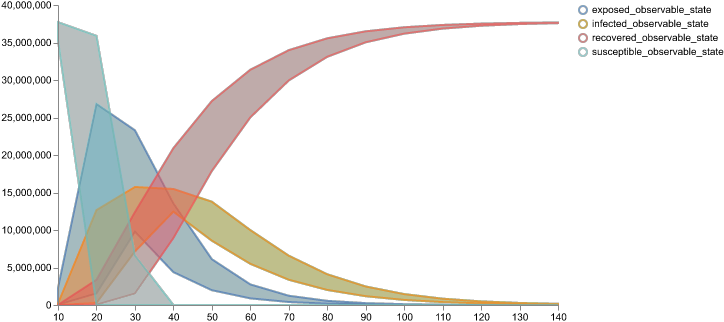

In [3]:
plots.ipy_display(schema)

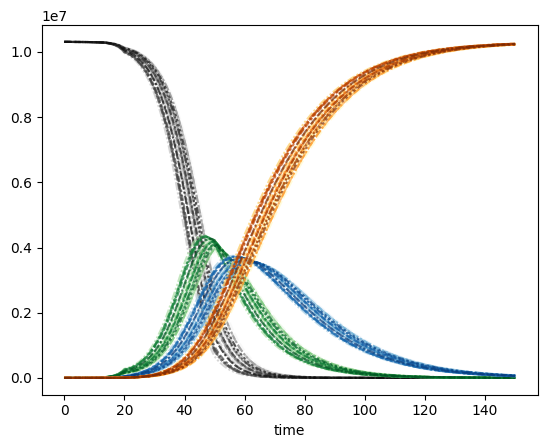

In [44]:
## Load required data
import pandas as pd
dataset = pd.read_csv("./Scenario 3 Supplementary/S3SimulationRuns.csv")
run_n = dataset[dataset.run==1].drop(['run',
                                      'R1','R2','R3',
                                      'S1','S2','S3',
                                      'E1','E2','E3'],axis=1)
y = ["_y","_m","_o"]
x = {"time":"Timestamp"}
x|= {"S"+str(i+1):"S"+y[i] for i in range(3)}
x|= {"E"+str(i+1):"E"+y[i] for i in range(3)}
x|= {"I"+str(i+1):"I"+y[i] for i in range(3)}
x|= {"R"+str(i+1):"R"+y[i] for i in range(3)}
run_n = run_n.rename(columns=x)
# run_n['I_sum'] = run_n.apply(lambda row: row.I_y+row.I_m+row.I_o, axis=1)

## Recreate the Scenario Figure (mostly)
agegroup = "1"
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="S"+agegroup),
             palette='Greys', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="E"+agegroup),
             palette='Greens', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="I"+agegroup),
             palette='Blues', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="R"+agegroup),
             palette='YlOrBr', alpha=.7, ax=ax)
ax.get_legend().remove()

In [45]:
display(run_n)

,Timestamp,I_y,I_m,I_o
0,0,50.000000,50.000000,50.000000
1,1,54.768440,56.236214,53.504963
2,2,67.125439,73.025243,62.006228
3,3,88.079043,101.792736,76.032978
4,4,119.905323,145.741121,96.857405
...,...,...,...,...
146,146,93899.681247,143757.159315,190702.985551
147,147,88749.605594,135880.603903,180558.121568
148,148,83874.991837,128424.684284,170931.516318
149,149,79261.677800,121367.829646,161798.477581


In [46]:
num_iterations = 100
data_mapping = {"I_y": "I_y","I_m":"I_m","I_o":"I_o"}
# data_mapping = {"I_sum":"infected_observable_state"}
%time calibrated_results = pyciemss.calibrate(model1, run_n, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/krue284/Local Files/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 150 rows of data. The first column, Timestamp, begins at 0 and ends at 150. The subsequent columns are named: I_y, I_m, I_o
CPU times: user 12min 39s, sys: 12.4 s, total: 12min 52s
Wall time: 12min 53s


{'persistent_beta': tensor(0.1413, grad_fn=<ExpandBackward0>)}

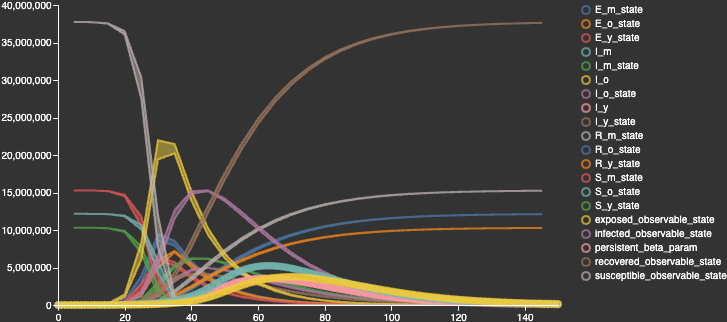

In [48]:
# Plot results for all states
logging_step_size = 5.0
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
schema = plots.trajectories(calibrated_sample_results["data"], #keep="I_.*", 
                            points = run_n.drop(['Timestamp'],axis=1))
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema,format='interactive')